## Dependencies

In [15]:
import numpy as np
import os
import glob
import math
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce
import time
import contextlib  

## Misc

In [2]:


@contextlib.contextmanager  
def timer(msg):
# A timer for speed test
    start = time.time()
    yield
    end = time.time()
    print("%s: %.02f ms" % (msg, (end-start)*1000))

In [3]:
# A wrapper to play music after the job is done.
def alarm(fn, sound = '/Users/Xiaoqing/Python/Downloaded/SoundResource/westworld.mp3'):

    def playmusic(fn):
        import pyglet
        from functools import wraps
    
        @wraps(fn)
        def inner(*args, **kwargs):
            result = fn(*args, **kwargs)           
            music_source = sound
            player = pyglet.media.load(music_source, streaming=False)
            player.play()         
            return result
    
        return inner
    
    return playmusic(fn)

import pyglet    
def playmusic(sound = '/Users/Xiaoqing/Python/Downloaded/SoundResource/westworld.mp3'):
    music_source = sound
    player = pyglet.media.load(music_source, streaming=False)
    player.play()

## Constants

In [4]:
#Bohr radius commonly used in DFT for reciprocal lattice scale. Not all BXSF files use it, though.
BOHR_R = 0.529177
#Rydberg constant for energy scale - again, a common DFT thing, but not all BXSF files use it.
RYDBERG = 13.6112
#electron mass
M_e = 5.68562958E-32 
# Planck constant
HBAR = 6.58211814E-16   

#Default scale for Igor Pro.
DEFAULT_SCALES = ((0,1),(0,1),(0,1))


## Main Code - BXSF loader

In [5]:
class BXSF(object):
# This starts with Xiaoyu Deng's code. Rewrote and added more functionality by Xiaoqing.
    def __init__(self, file, scaling = True):
        self.e_scaling = RYDBERG if scaling else 1
        self.name = file
        self.path = "/".join(file.rstrip().rsplit("/")[:-1])
        self.basename = file.rsplit("/")[-1].rsplit(".")[0].replace("-","_")
        try:
            self.f = open(file, 'r')
            self.content = self.f.readlines()
            # Need to rewrite this for better memory management.
            # For BXSF file the data iterated first on Z, then Y then X in the reciprocal space.
            # For Igor pro the data goes as row (x), column (y), layer (z). This can be quite confusing as Z become x, etc..
            # Specifically Igor save its data in the format of column/row/layer which is reverse of what we expect.
            # We have to transpose the 3D matrix to satisfy Igor, so Z->x, X->y, Y->z.
            self.ef = self._get_ef()
            self.xstep, self.ystep, self.zstep = self._get_gridsize()      
            self.matrix = self._get_rpl_vector()*2*np.pi/BOHR_R if scaling else self._get_rpl_vector()
            self.inv_matrix = np.linalg.inv(self.matrix)
            # 3 reciprocal vectors (2*pi/a, 2*pi/b, 2*pi/c).
            # These vector forms the transformation matrix from reciprocal to Cartesian system: 
            # a = b*M, b = a*M**(-1) where a is the Cartesasian coordinates and b is the reciprocal coordinates.           
            self.rpl_scales = list(zip([0,0,0],map(getR, self.matrix)))
            
            #self.band_start = self._findtag("BAND:")
            #self.band_num = self.content[self.band_start].rstrip().rsplit()[-1] if self.band_start!=-1 else 0
            #self.igor_name = "".join([self.basename,"_BAND",self.band_num])
            # get the first band and its interpolation - there might be multiple bands in a file.
            self.bands = dict()
            self.band_num = 0
            self.line_pointer = self._findtag("BAND:")
            while self.content[self.line_pointer].find('END_BANDGRID_3D')==-1 and self.line_pointer!=len(self.content)-1:
                self.get_rpl_band()
                self.bands[self.band_num] = self.rpl_band
            print(len(self.bands), " bands loaded.")

            self._get_band_ranges()
            self._rpl2cart_grids()
            self._init_dispgrid()
            
        except  OSError as e:
            print(file," not found")
            
    def _load_param(self):
    # Placeholder for parameter loading
        pass
                                    
    def __del__(self):
        self.f.close()

    def _findtag(self,tag):
        for i,line in enumerate(self.content):
            if tag in line:
                return i
        return -1
    
    def _get_ef(self):
        for line in self.content:
            if "Fermi Energy" in line:
                self.ef = float(line.rstrip().rsplit()[-1])
                return self.ef
        
    def _get_gridsize(self):
        pos = self._findtag("BEGIN_BLOCK_BANDGRID_3D")
        line = self.content[pos+4]
        nx, ny, nz =[int(step) for step in line.rstrip().rsplit()]
        return nx, ny, nz
    
    def _get_rpl_vector(self):
        pos = self._findtag("BEGIN_BLOCK_BANDGRID_3D")
        self.xvector = tuple(map(float,self.content[pos+6].rstrip().rsplit()))
        self.yvector = tuple(map(float,self.content[pos+7].rstrip().rsplit()))
        self.zvector = tuple(map(float,self.content[pos+8].rstrip().rsplit()))
        return np.asarray((self.xvector, self.yvector, self.zvector))
     
    
    def get_rpl_band(self):
    # Read the current band as a numpy 3D array in reciprocal lattice, starting from self.band_start
        pos = 0
        self.rpl_band = np.empty(self.xstep*self.ystep*self.zstep)
        line = self.content[self.line_pointer]
        self.band_num = int(line.rstrip().rsplit()[-1])

        self.line_pointer+=1
        line = self.content[self.line_pointer]
        while "BAND" not in line and "END" not in line: 
            data = line.rstrip().rsplit()
            for j,element in enumerate(data): 
                self.rpl_band[pos+j]=(float(element)-self.ef)*self.e_scaling
            pos+=j+1
            self.line_pointer+=1
            line = self.content[self.line_pointer]
            
        self.rpl_band.resize((self.xstep,self.ystep,self.zstep))
            
    def _get_interp(self,band):
    # Interpolate the band in reciprocal space for ARPES simulation
        x=np.linspace(0,1,self.xstep)
        y=np.linspace(0,1,self.ystep)
        z=np.linspace(0,1,self.zstep)  
        self.interp=RegularGridInterpolator((x,y,z),band) 
        
    def _init_dispgrid(self, k_step = 301, k_scale = 1.5, be_min = -2, be_max = 1, be_step = 301):
    # Initialize the grids (kx, ky, E) to host the ARPES spectra in Cartesian space with default values.
        self.set_e_scale(be_min, be_max, be_step)
        self.set_kx_scale(-k_scale, k_scale, k_step)
        self.set_ky_scale(-k_scale, k_scale, k_step)
        
    def set_e_scale(self, be_min, be_max, be_step):
    # Set the binding energe range for the ARPES simulation. Only the bands with-in this energy range are considered.
    # Called by user only when you need to customize the setting. 
        self.be_min = be_min
        self.be_max = be_max
        self.e_step = be_step
        self.e_axis = np.linspace(be_min, be_max, be_step)
        self._get_relevant_bands()
        
    def set_kx_scale(self, kx_min, kx_max, kx_step):
    # Set the momentum range for the ARPES simulation. 
    # Called by user only when you need to customize the setting. 
        self.kx_axis = np.linspace(kx_min, kx_max, kx_step)
        self.kx_step= kx_step
        self.kx_min = kx_min
        self.kx_max = kx_max
         
    def set_ky_scale(self, ky_min, ky_max, ky_step):
        self.ky_axis = np.linspace(ky_min, ky_max, ky_step)
        self.ky_step = ky_step
        self.ky_min = ky_min
        self.ky_max = ky_max
    
    def get_disp(self, steps, path):
    # Get the dispersion as a 1D numpy array with $steps$ elements along a given path. Say high symmetry line.
        pass
    
    def _rpl2cart_grids(self):
    # make a Cartesian coordinate grids that is large enough to contain the entire reciprocal lattice.
        cart_max = np.sum(np.abs(self.matrix), axis=0)
        self.cart_scales = list(zip(-cart_max, cart_max))
        self.cart_nx, self.cart_ny, self.cart_nz = 2*self.xstep-1, 2*self.ystep-1, 2*self.zstep-1
        cart_grids=np.mgrid[-cart_max[0]:cart_max[0]:complex(0,self.cart_nx),
                           -cart_max[1]:cart_max[1]:complex(0,self.cart_ny),
                           -cart_max[2]:cart_max[2]:complex(0,self.cart_nz)]
        cart_grids = cart_grids.reshape(3,-1).T
        k_rpl = np.dot(cart_grids, self.inv_matrix)
        self.k_rpl = abs(k_rpl)%1
        
    def get_cart_band(self, band_num):
    # Get the band structure under this Cartesian coordinates instead of the reciprical coordinates.
    # Normally that's what we want - otherwise it might be counter
    # Deal with the whole array at the same time, i.e. matrix operation. Much faster.
        self._get_interp(band_num)
        self.cart_band =  self.interp(self.k_rpl)
        self.cart_band.resize((self.cart_nx,self.cart_ny,self.cart_nz))
       
    def kz_sim(self, hkl=[0,0,1], broadening = 0.01, kz = 0):
        # Simulate ARPES spectra at a certain hkl face for a given k_z - not finished yet.
        self.miller = miller_matrix(self.matrix, hkl)
        self.hkl = hkl
        xv, yv, ev = np.meshgrid(self.kx_axis,self.ky_axis,self.e_axis)
        zv = ev*0+kz
        k_cart = np.stack([xv,yv,zv]).reshape(3,-1).T
        k_cart = np.dot(k_cart, self.miller)
        self.ek3d = self.ek_at_cart(k_cart)
        self.ek3d.resize(self.k_step, self.k_step, self.e_step)
        self.ARPES3d = broadening/(broadening**2+(ev-self.ek3d)**2)
        
    def ARPES_sim(self, hv=75, inner =10, wk = 4.27, hkl=[0,0,1], broadening = 0.01):

        # Simulate ARPES spectra at a certain hkl face.
        self.e_off = hv+inner-wk
        self.miller = miller_matrix(self.matrix, hkl)
        self.hkl = hkl
        xv, yv, ev = np.meshgrid(self.kx_axis,self.ky_axis,self.e_axis)
        zv = self._kxky2kz(xv,yv,ev)
        k_cart = np.stack([xv,yv,zv]).reshape(3,-1).T
        k_cart = np.dot(k_cart, self.miller)
        
        self.ARPES3d  =np.zeros((self.kx_step, self.ky_step, self.e_step))
        print(len(self.relevant)," bands found in range. Processing....")
        for band_num in self.relevant:
            self._get_interp(self.bands[band_num])
            self.ek3d = self.ek_at_cart(k_cart)
            self.ek3d.resize(self.kx_step, self.ky_step, self.e_step)
            band3d = broadening/(broadening**2+(ev-self.ek3d)**2)
            self.ARPES3d =np.add(self.ARPES3d,band3d)
        
    def _get_band_ranges(self):
        self.band_tops = {}
        self.band_bottoms = {}
        for band_num in self.bands:
            self.band_tops[band_num] = self.bands[band_num].max()
            self.band_bottoms[band_num] = self.bands[band_num].min()
        
    def _get_relevant_bands(self):
        # determine which bands are relevant, i.e. between self.be_min and self.be_max
        self.relevant = []
        for band_num in self.bands:
            if self.band_tops[band_num]>self.be_min and self.band_bottoms[band_num]<self.be_max:
                self.relevant.append(band_num)
        
    def ARPES2itx(self, str_type = "<U8", igor_name = None, out_name = None):
    #write the simulated ARPES spectra to igor file.
        band_out = self.ARPES3d
        hkl_str = "".join([str(i) for i in self.hkl]).replace("-","n")
        if not igor_name:
            igor_name ="".join([self.basename,"_",hkl_str])
        if not out_name:
            out_name = "".join([self.path,"/",self.basename,"_",hkl_str,".itx"])  
        scales = ((self.kx_min, self.kx_max),(self.ky_min, self.ky_max),(self.be_min,self.be_max))
        write2itx(band_out, igor_name, out_name, scales = scales,str_type = str_type)            
    
    def _kxky2kz(self, kx, ky, be):
        E = self.e_off+be
        return np.sqrt(2*M_e*E/(HBAR**2)-kx**2-ky**2)
    
    def ek_at_cart(self,cart):
        # Get the energy value of a band under the Cartesian coordinate"cart", which is a numpy array of size 3.
        # Can handle arrays of Cartesian coordinates too for parallel computation.
        # need to have self.interp for a particular band
        k_rpl = np.dot(cart, self.inv_matrix)
        k_rpl = abs(k_rpl%1)
        return self.interp(k_rpl)
                    
    def band2itx(self, band_num, unit = "cart"):
    # write the 3D E(kx,ky,kz) data to Igor Pro .itx file for a single band.
    # Intuitively we want the band structure under Cartesian coordinates.
        igor_name = self.basename+"_"+str(band_num)
        out_name = "".join([self.path,"/",igor_name,".itx"])
        if band_num not in self.bands:
            print("Target band cannot be found.")
            return False
        if unit=="rpl":
            scales = self.rpl_scales
            band_out = self.bands[band_num]
        elif unit=="cart":
            self.get_cart_band(band_num)
            scales = self.cart_scales
            band_out = self.cart_band
            
        write2itx(band_out, igor_name, out_name, scales=scales) 
        return True
    
    def allbands_to_itx(unit = "cart"):
        for band_num in self.bands:
            band2itx(band_num)
               
        
def make_igorhead(steps, igor_name):
    igorhead = "".join(["IGOR\nWAVES/D/N=(",",".join([str(step) for step in steps]),") ",igor_name,"\n"+"BEGIN\n"])
    return igorhead

def make_igortail(scales, igor_name):
    igortail = []
    igortail.append("\nEND\nX ")
    axes = ["x","y","z","d"]
    for i, scale in enumerate(scales):
        igortail.append("Setscale/I {0} {1},{2},\"\", {3};".format(axes[i],scale[0], scale[1], igor_name))     
    return "".join(igortail)

def write2itx(data3d, igor_name, out_name, scales = DEFAULT_SCALES, str_type = "<U8", note = "\n"):
    # Igor_name: the wave name inside Igor
    # out_name: actual file name
    nx, ny, nz = data3d.shape 
    #Here the key operation: swap the axes of the matrix x,y and y,z
    band_out = np.transpose(data3d,(2,0,1)).astype(str_type)
    band_out = band_out.flatten()
    band_out.resize((nz*nx, ny))
    with open(out_name,"w") as output:
        igorhead = make_igorhead((nx,ny,nz),igor_name)
        igortail = make_igortail(scales,igor_name)
        output.write(igorhead)
        output.write("\n".join(["\t".join(row) for row in band_out]))
        output.write(igortail)
        wavenote="".join(["X Note ",igor_name,",",note])
        output.write(wavenote)
        print(out_name, " generated.")

def getR(vector):
    return np.sqrt(sum(i**2 for i in vector))

def miller_matrix(b_matrix, hkl):
    # Note that it is easier to imagine cleavage plane in real space, but here we are....
    # Miller index - defines a surface that perpendicular to g_hkl = h*b1+k*b2+l*b3 in reciprocal lattice.
    # so this can be understood as a Cartesian system being rotated so that unit vector c rotated to g_hkl.
    # which defines a rotation matrix. We use two steps: first rotate counter-clockwise around axis Z, then axis Y
    g_hkl = np.sum(np.asarray([[i] for i in hkl])*b_matrix,axis = 0)
    x,y,z = g_hkl
    if x or y:
        cos_t = x/np.sqrt(x**2+y**2) 
        sin_t = y/np.sqrt(x**2+y**2)
    else:
        cos_t = 1
        sin_t = 0
    cos_p = z/np.sqrt(x**2+y**2+z**2)
    sin_p = np.sqrt(x**2+y**2)/np.sqrt(x**2+y**2+z**2)
    Rz = np.array([[cos_t,-sin_t, 0],[sin_t, cos_t, 0],[0, 0, 1]])
    Ry = np.array([[cos_p,0, sin_p],[0,1,0],[-sin_p,0,cos_p]])
    # rotation matrix that converts the hkl coordinates back to the original.
    return np.linalg.inv(np.dot(Ry,Rz))


## Example - MnBiTe147

In [16]:
# the cleavage surface defined by Miller index and the photon energy.
my_hkl = [0,0,1]
my_hv = 90

In [9]:
%%time

# A typical example where a single file holds many bands.
# be careful with E_F - the program will try look for it in the file but you might need to get the actual number from DFT people.


MBT147 = BXSF("/Users/Xiaoqing/ARPES_Win/OtherSamples/MnBiTe/MBT147.bxsf", scaling = False)
playmusic()

152  bands loaded.
CPU times: user 37.5 s, sys: 6.27 s, total: 43.7 s
Wall time: 52.2 s


In [10]:
# change energy scales and steps to narrow down the number of relevant bands.
# This should match your experimental energy range with some offset.
# The default value is (start, end, steps) = (-2,1,301)
MBT147.set_e_scale(-1,0.2,121)

In [12]:
%%time
# Very time consuming. Takes a long time to do this - 42 secs for one band on the default 301*301*301 grid
# Here we use use coarser grids and narrower range than default values to to speed things up.
MBT147.set_kx_scale(-0.5,0.5,101)
MBT147.set_ky_scale(-0.5,0.5,101)
MBT147.ARPES_sim(hv = my_hv, hkl=my_hkl, inner = 15, broadening = 0.02)
# play music after the job is done. Or use the wrap decorator.
playmusic()

34  bands found in range. Processing....
CPU times: user 33 s, sys: 8.21 s, total: 41.2 s
Wall time: 38.6 s


In [13]:
# "Translate" the 3D numpy array to igor's itx file, so you can use image tool.
MBT147.ARPES2itx()

/Users/Xiaoqing/ARPES_Win/OtherSamples/MnBiTe/MBT147_001.itx  generated.


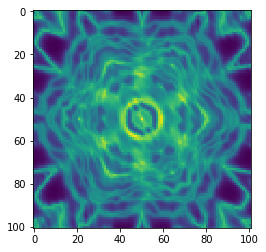

In [18]:
plt.imshow(MBT147.ARPES3d[:,:,9])

## CuMnAs

In [94]:
hkl = [1,0,0]
hv = 86
scales = ((-1.5,1.5),(-1.5,1.5),(-3,1))

hkl_str = "".join([str(i) for i in hkl]).replace("-","n")
wavenote ={}
wavenote["hv"] = hv
wavenote["hkl"] = hkl_str

In [95]:
CMA_bands = []
for _ in range(6):
    CMA.get_rpl_band()
    CMA.get_interp()
    CMA.ARPES_sim(hkl=hkl, hv = hv)
    CMA_bands.append(CMA.ARPES3d)

In [96]:
CMA_ARPES86 = reduce(lambda x,y:np.add(x,y), CMA_bands)
igor_name = "CMA_ARPES"+hkl_str
outname="/Users/Xiaoqing/ARPES_Win/OtherSamples/CuMnAs/"+igor_name+".itx"
note = str(wavenote)
write2itx(CMA_ARPES86, igor_name, outname, note=note, scales =scales, str_type = "<U8")

/Users/Xiaoqing/ARPES_Win/OtherSamples/CuMnAs/CMA_ARPES100.itx  generated.


## NbAs2

In [19]:
# In some cases, DFT people will send multiple file, each corresponds to a single band.

NbAs2_band87 = BXSF("/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/NbAs2-pri-soc.bxsf.band-87")
NbAs2_band85 = BXSF("/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/NbAs2-pri-soc.bxsf.band-85")
NbAs2_band83 = BXSF("/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/NbAs2-pri-soc.bxsf.band-83")
NbAs2_band81 = BXSF("/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/NbAs2-pri-soc.bxsf.band-81")
NbAs2_band79 = BXSF("/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/NbAs2-pri-soc.bxsf.band-79")

1  bands loaded.
1  bands loaded.
1  bands loaded.
1  bands loaded.
1  bands loaded.


In [21]:
hkl = [1,0,-1]
hv = 90
scales = ((-1.5,1.5),(-1.5,1.5),(-2,1))
hkl_str = "".join([str(i) for i in hkl]).replace("-","n")
wavenote ={}
wavenote["hv"] = hv
wavenote["hkl"] = hkl_str
bands = (NbAs2_band87,NbAs2_band85,NbAs2_band83,NbAs2_band81,NbAs2_band79)

In [22]:
for band in bands:
    band.ARPES_sim(hkl=hkl, hv = hv)
NbAs2_ARPES = NbAs2_band87.ARPES3d+NbAs2_band85.ARPES3d+NbAs2_band83.ARPES3d+NbAs2_band81.ARPES3d+NbAs2_band79.ARPES3d
igor_name = "NbAs2_ARPES"+hkl_str
outname="/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/"+igor_name+".itx"
write2itx(NbAs2_ARPES, igor_name, outname, scales =scales, str_type = "<U8")

1  bands found in range. Processing....
1  bands found in range. Processing....
1  bands found in range. Processing....
1  bands found in range. Processing....
1  bands found in range. Processing....
/Users/Xiaoqing/ARPES_Win/OtherSamples/NbAs2/NbAs2-band-scan/NbAs2_ARPES10n1.itx  generated.


## NbGe2

## Other loaders

In [47]:
class surface_loader():
# A temporary code to load Qihang's 2D surface band plot
    import math
    def __init__(self, file):
        self.out_name = file+".itx"
        with open(file, "r") as f:
            self.xv, self.yv, self.intensity, self.weight = self._parser(f.readlines())
        self.scales = self._get_scales()
        vector_exp = np.vectorize(math.exp)
        self.projection = vector_exp(self.weight+10)
        self.intensity.resize((self.xstep, self.ystep))
        self.projection.resize((self.xstep, self.ystep))
        
    def _parser(self, content):  
        xv, yv, intensity, weight = [],[],[],[]
        count = 0
        
        for idx, line in enumerate(content):
            try:
                x, y, i, w = line.strip().split() 
                xv.append(float(x))
                yv.append(float(y))
                intensity.append(float(i))
                weight.append(float(w))
            except:
                if line.strip()!="":
                    print("Error occurs at ", line)
        xv = np.array(xv)
        yv = np.array(yv)
        intensity = np.array(intensity)
        weight = np.array(intensity)
        return xv, yv, intensity, weight
                
    def _get_steps(self):
        prev = self.xv[0]
        for idx, x in enumerate(self.xv):
            if x!=prev:
                ystep = idx
                break
            prev = x
        
        xstep = len(self.xv)//ystep
        return xstep, ystep
    
    def _get_scales(self):
        self.xstep, self.ystep = self._get_steps()
        self.xwave = self.xv[::self.ystep]
        self.ywave = self.yv[:self.ystep]
        return ((self.xwave[0],  self.xwave[-1]),(self.ywave[0], self.ywave[-1]))

    def data2itx(self, note = "", projection = False):
        if projection:
            out_data = self.projection.astype("<U8")
            igor_name = "ss_projection"
        else:
            out_data = self.intensity.astype("<U8")
            igor_name = "ss_intensity"
            
        with open(self.out_name, "w") as output:
            igorhead = make_igorhead((self.xstep,self.ystep),igor_name)
            igortail = make_igortail(self.scales,igor_name)
            output.write(igorhead)
            output.write("\n".join(["\t".join(row) for row in out_data]))
            output.write(igortail)
            wavenote="".join(["X Note ",igor_name,",",note])
            output.write(wavenote)
            print(self.out_name, " generated.")


In [ ]:
file = "/Users/Xiaoqing/ARPES_Win/OtherSamples/MnBiTe/Surface/dos.dat_r"
surface = surface_loader(file)
surface.data2itx(projection=True)

In [ ]:
# specific for PbPd3 and SnPd3's DFT data as it has a different format.
def DFT_loaderPbPd3(file):
    with open(file, "r") as f:
        content = f.readlines()
        for i,line in enumerate(content):
            if line.isspace():
                break
        step = i-1
        scale = float(content[step].rstrip().rsplit()[2])
   #     print(step, scale)
        
        band = np.empty(step**3,dtype = "<U32")
        
        i=0
        for line in content[1:]:
            if not line.isspace():
                try:
                    value = line.rstrip().rsplit()[3]
                    band[i]=value
                    i+=1
                except:
                    print(i)
        band.resize((step**2,step))
        
        outname =file.replace(".dat", ".itx")
        basename = file.rsplit("/")[-1].replace(".dat","").replace("-","_")
        igorhead = "IGOR\nWAVES/D/N=("+",".join([str(step),str(step),str(step)])+") "+basename+"\n"+"BEGIN\n"
        igortail = "\nEND\nX "
        igortail+= "Setscale/I x 0,%f,\"\", %s;" % (scale, basename)  
        igortail+= "Setscale/I y 0,%f,\"\", %s;" % (scale, basename)  
        igortail+= "Setscale/I z 0,%f,\"\", %s;" % (scale, basename)
        igortail+= "Setscale/I d 0,%f,\"\", %s;" % (0, basename)  
        
        with open(outname,"w") as output:
                output.write(igorhead)
                output.write("\n".join(["\t".join(row) for row in band]))  
                output.write(igortail)
